In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate
import netCDF4 as nc
import xarray as xr
import scipy.ndimage
import scipy as sp
import alphashape
from matplotlib import ticker, cm
from scipy import interpolate
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
from matplotlib import style
from pathlib import Path  
style.use('default') or plt.style.use('default')
import seaborn as sns


In [2]:
# Read in velocity and coordinate data

Sims = ['n3E0.5_SV', 'n4E1.8_SV', 'n3E0.5dsdt50Age1000', 'n4E1.8dsdt50Age1000']
VelData = {}
for i in Sims:
    VelData[i] = pd.read_csv('../Simulations/DerwaelSimulations/2DVelocities/' + str(i) + '.csv', sep=",")


In [3]:
# Create a regular grid and interpolate the data onto it

VelocityGridded_x = {}
VelocityGridded_y = {}

xmin, xmax = min(VelData[Sims[0]]['Points:0']), max(VelData[Sims[0]]['Points:0'])
ymin, ymax = min(VelData[Sims[0]]['Points:1']), max(VelData[Sims[0]]['Points:1'])
dist = 100
nx, ny = int((xmax - xmin)/dist + 1), int((ymax - ymin)/dist + 1)
x = np.linspace(xmin, xmax, nx)
y = np.linspace(ymin, ymax, ny)
grid_x, grid_y = np.meshgrid(x, y)

for i in Sims:
    VelocityGridded_x[i] = scipy.interpolate.griddata((VelData[i]["Points:0"], VelData[i]["Points:1"]), VelData[i]["velocity:0"], (grid_x, grid_y), method='linear')
    VelocityGridded_y[i] = scipy.interpolate.griddata((VelData[i]["Points:0"], VelData[i]["Points:1"]), VelData[i]["velocity:1"], (grid_x, grid_y), method='linear')

    
#vx = scipy.interpolate.griddata((VelData["Points:0"], VelData["Points:1"]), VelData["velocity:0"], (grid_x, grid_y), method='linear')
#vy = scipy.interpolate.griddata((VelData["Points:0"], VelData["Points:1"]), VelData["velocity:1"], (grid_x, grid_y), method='linear')


In [4]:
# Calculate the horizontal velocity magnitude

VelocityMagnitude = {}
vx_norm = {}
vy_norm = {}
J = len(VelocityGridded_x[Sims[0]])
K = len(VelocityGridded_x[Sims[0]][0])
for i in Sims:
    VelocityMagnitude[i] = np.zeros_like(VelocityGridded_x[Sims[0]])
    for j in range(1, J-1):
        for k in range(1, K-1):
            VelocityMagnitude[i][j][k] = np.sqrt(VelocityGridded_x[i][j][k]**2 + VelocityGridded_y[i][j][k]**2)

    vx_norm[i] = np.divide(VelocityGridded_x[i], VelocityMagnitude[i], out=np.zeros_like(VelocityGridded_x[Sims[0]]), where=VelocityMagnitude[i]!=0)
    vy_norm[i] = np.divide(VelocityGridded_y[i],  VelocityMagnitude[i], out=np.zeros_like(VelocityGridded_x[Sims[0]]), where=VelocityMagnitude[i]!=0)
    


In [5]:
# Read in grounding line data

dfGL = pd.read_csv("/Users/clara.henry/Documents/Derwael/Data/GroundingLine.csv")

points = np.column_stack((list(dfGL["Points:0"])[::10], list(dfGL["Points:1"])[::10]))

# [list(dfGL["Points:0"]), list(dfGL["Points:1"])]
alpha = 0.95 * alphashape.optimizealpha(points)
hull = alphashape.alphashape(points, alpha)
hull_pts = hull.exterior.coords.xy

hull_pts = hull_pts

for i in range(len(hull_pts[0])):
    hull_pts[0][i] = hull_pts[0][i]
    hull_pts[1][i] = hull_pts[1][i]
    
poly = Polygon(zip(list(hull_pts[0]), list(hull_pts[1])))



/Users/clara.henry/opt/anaconda3/lib/python3.9/site-packages/shapely/ops.py:42: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  source = iter(source)
/Users/clara.henry/opt/anaconda3/lib/python3.9/site-packages/alphashape/optimizealpha.py:41: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  return all([polygon.intersects(point) for point in points])


In [6]:

for k in range(2,4):
    for i in range(len(x)):
        for j in range(len(y)):
            boolean = poly.contains(Point(x[i], y[j]))
            if boolean == False:
                VelocityMagnitude[Sims[k]][j][i] = 'nan'
                vx_norm[Sims[k]][j][i] = 'nan'
                vy_norm[Sims[k]][j][i] = 'nan'


In [7]:
for i in range(len(hull_pts[0])):
    hull_pts[0][i] = hull_pts[0][i]/1000
    hull_pts[1][i] = hull_pts[1][i]/1000


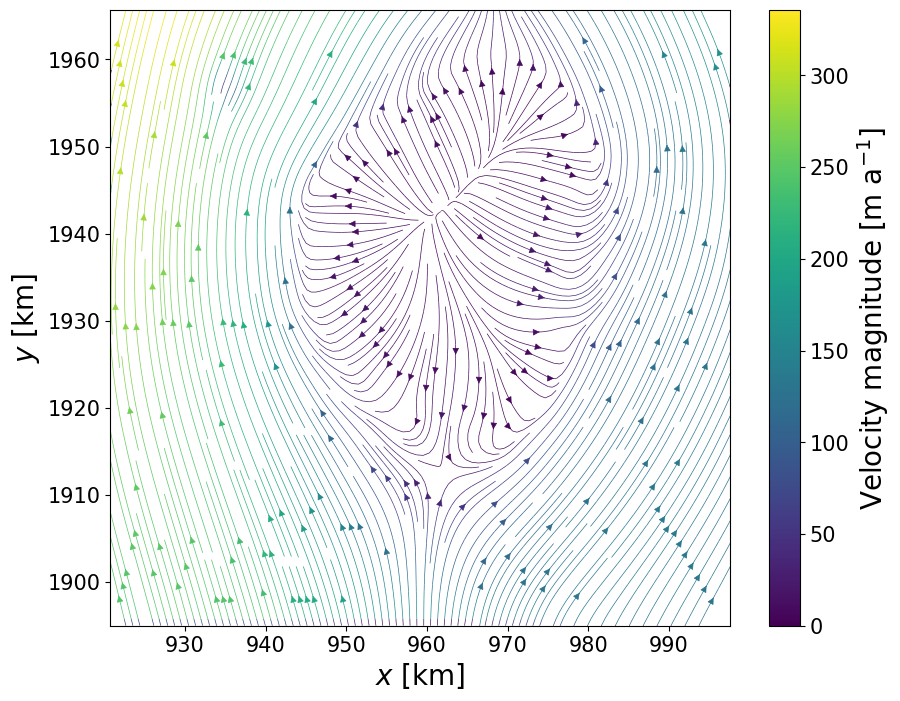

In [8]:
# Plot the velocity for n=3

i = 0

fig, ax = plt.subplots(1, 1, figsize=(10, 8))
cmap='viridis'
strm = ax.streamplot(grid_x/1000, grid_y/1000, vx_norm[Sims[i]], vy_norm[Sims[i]], density=[3, 3],\
                     linewidth=0.5, color=VelocityMagnitude[Sims[i]], cmap=cmap)
cbar = fig.colorbar(strm.lines)

ax.set_xlabel(r'$x$ [km]', size=20)
ax.set_ylabel(r'$y$ [km]', size=20)
ax.tick_params(axis='both', labelsize=15)
cbar.ax.tick_params(labelsize=15)
cbar.set_label('Velocity magnitude [m a$^{-1}$]', size=20)
fig.savefig('../Figures/DerwaelVelocity' + str(Sims[i]) + '.jpg', format='jpg', dpi=700, bbox_inches = "tight")


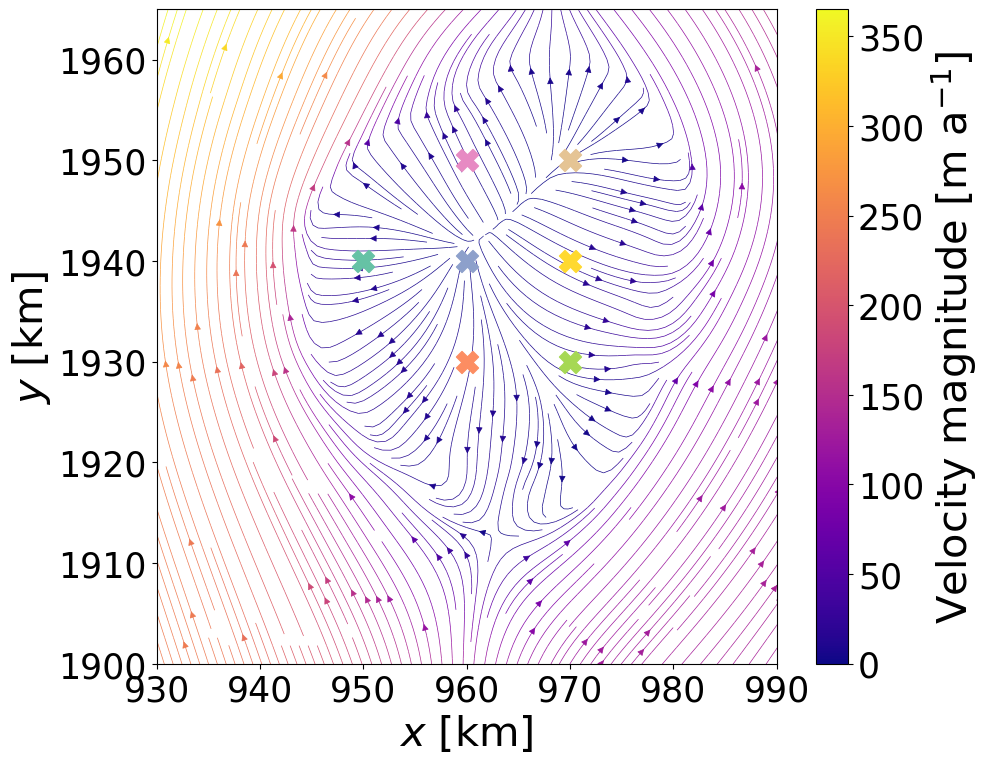

In [9]:
# Plot the velocity for n=4
colors2 = sns.color_palette("Set2").as_hex()
i = 1

fig, ax = plt.subplots(1, 1, figsize=(10, 8.5))
cmap='plasma'
strm = ax.streamplot(grid_x/1000, grid_y/1000, vx_norm[Sims[i]], vy_norm[Sims[i]], density=[3, 3],\
                     linewidth=0.5, color=VelocityMagnitude[Sims[i]], cmap=cmap, zorder=0)
cbar = fig.colorbar(strm.lines)

ax.scatter(950, 1940, marker='X', color=colors2[0], s=250, zorder=1)
ax.scatter(960, 1930, marker='X', color=colors2[1], s=250, zorder=1)
ax.scatter(960, 1940, marker='X', color=colors2[2], s=250, zorder=1)
ax.scatter(960, 1950, marker='X', color=colors2[3], s=250, zorder=1)
ax.scatter(970, 1930, marker='X', color=colors2[4], s=250, zorder=1)
ax.scatter(970, 1940, marker='X', color=colors2[5], s=250, zorder=1)
ax.scatter(970, 1950, marker='X', color=colors2[6], s=250, zorder=1)
ax.set_xticks([930, 940, 950, 960, 970, 980, 990])
ax.set_yticks([1900, 1910, 1920, 1930, 1940, 1950, 1960])
ax.set_xlim(930, 990) 
ax.set_ylim(1900, 1965) 
ax.set_xlabel(r'$x$ [km]', size=30)
ax.set_ylabel(r'$y$ [km]', size=30)
ax.tick_params(axis='both', labelsize=25)
cbar.ax.tick_params(labelsize=25)
cbar.set_label('Velocity magnitude [m a$^{-1}$]', size=30)
fig.savefig('../Figures/DerwaelVelocityProfiles.jpg', format='jpg', dpi=700, bbox_inches = "tight")


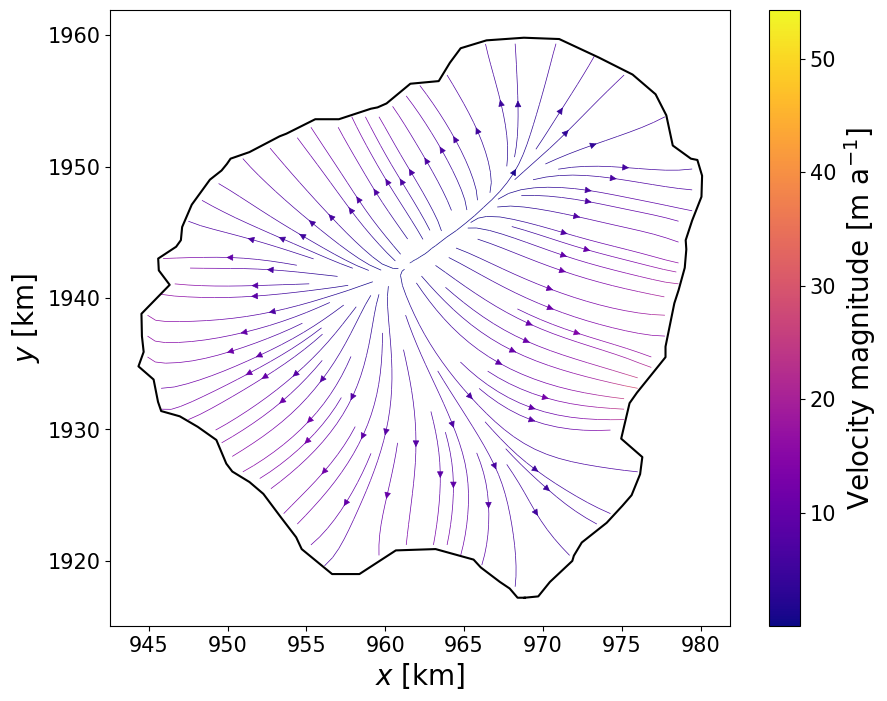

In [10]:
# Plot the velocity for n=4

i = 2

fig, ax = plt.subplots(1, 1, figsize=(10, 8))
cmap='plasma'
strm = ax.streamplot(grid_x/1000, grid_y/1000, vx_norm[Sims[i]], vy_norm[Sims[i]], density=[3, 3],\
                     linewidth=0.5, color=VelocityMagnitude[Sims[i]], cmap=cmap)
cbar = fig.colorbar(strm.lines)
ax.plot(hull_pts[0], hull_pts[1], color='black')
ax.set_xlabel(r'$x$ [km]', size=20)
ax.set_ylabel(r'$y$ [km]', size=20)
ax.tick_params(axis='both', labelsize=15)
cbar.ax.tick_params(labelsize=15)
cbar.set_label('Velocity magnitude [m a$^{-1}$]', size=20)
fig.savefig('../Figures/DerwaelVelocity' + str(Sims[i]) + '.jpg', format='jpg', dpi=700, bbox_inches = "tight")


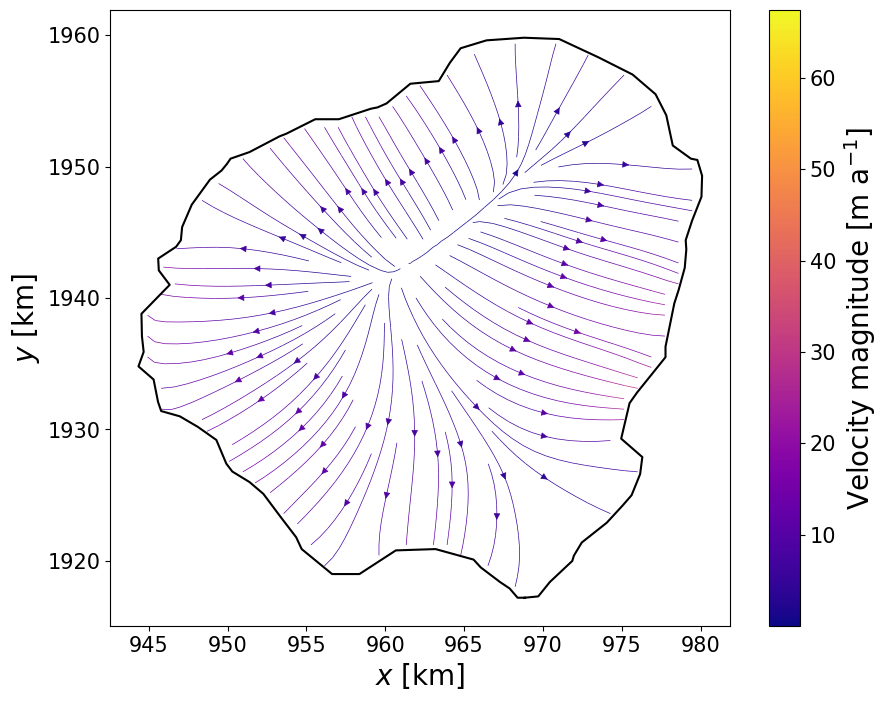

In [11]:
# Plot the velocity for n=4

i = 3

fig, ax = plt.subplots(1, 1, figsize=(10, 8))
cmap='plasma'
strm = ax.streamplot(grid_x/1000, grid_y/1000, vx_norm[Sims[i]], vy_norm[Sims[i]], density=[3, 3],\
                     linewidth=0.5, color=VelocityMagnitude[Sims[i]], cmap=cmap)
cbar = fig.colorbar(strm.lines)
ax.plot(hull_pts[0], hull_pts[1], color='black')
ax.set_xlabel(r'$x$ [km]', size=20)
ax.set_ylabel(r'$y$ [km]', size=20)
ax.tick_params(axis='both', labelsize=15)
cbar.ax.tick_params(labelsize=15)
cbar.set_label('Velocity magnitude [m a$^{-1}$]', size=20)
fig.savefig('../Figures/DerwaelVelocity' + str(Sims[i]) + '.jpg', format='jpg', dpi=700, bbox_inches = "tight")


In [12]:
# Subtract n=3 velocity from n=4 velocity

VelDiffSurf = VelocityMagnitude[Sims[1]] - VelocityMagnitude[Sims[0]]
VelDiffPercSurf = 100 * (VelocityMagnitude[Sims[1]] - VelocityMagnitude[Sims[0]]) / (VelocityMagnitude[Sims[1]] + VelocityMagnitude[Sims[0]])

VelDiff1000 = VelocityMagnitude[Sims[3]] - VelocityMagnitude[Sims[2]]
VelDiffPerc1000 = 100 * (VelocityMagnitude[Sims[3]] - VelocityMagnitude[Sims[2]]) / (VelocityMagnitude[Sims[3]] + VelocityMagnitude[Sims[2]])


/var/folders/7m/lgqxn0610bs8sxwnf4k6z_hw0000gn/T/ipykernel_6095/3819647446.py:4: RuntimeWarning: invalid value encountered in true_divide
  VelDiffPercSurf = 100 * (VelocityMagnitude[Sims[1]] - VelocityMagnitude[Sims[0]]) / (VelocityMagnitude[Sims[1]] + VelocityMagnitude[Sims[0]])


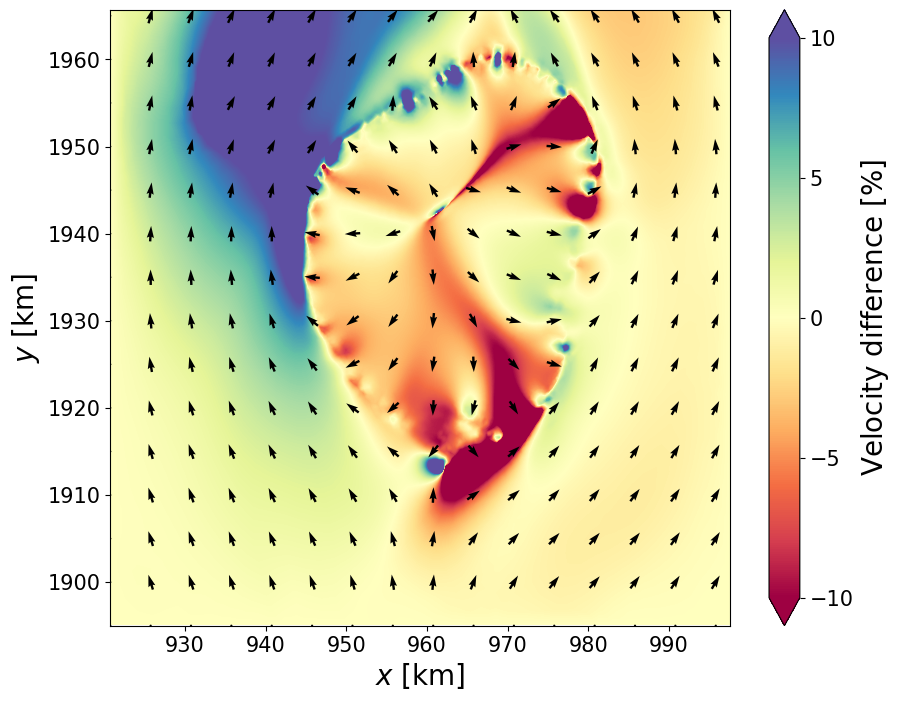

In [13]:
# Plot velocity difference

fig, ax = plt.subplots(1, 1, figsize=(10, 8))
CS = ax.contourf(grid_x/1000, grid_y/1000, VelDiffPercSurf, levels=np.linspace(-10.0,10.0,500), cmap="Spectral", extend = 'both')
skip = (slice(None, None, 50), slice(None, None, 50))
ax.quiver(grid_x[skip]/1000, grid_y[skip]/1000, vx_norm[Sims[0]][skip], vy_norm[Sims[0]][skip], scale=40, pivot='mid')

ax.set_xlabel(r'$x$ [km]', size=20)
ax.set_ylabel(r'$y$ [km]', size=20)
ax.tick_params(axis='both', labelsize=15)
cbar = fig.colorbar(CS, ticks=[-10, -5, 0, 5, 10])
cbar.ax.tick_params(labelsize=15)
cbar.set_label('Velocity difference [$\%$]', size=20)
fig.savefig('../Figures/DerwaelSurfaceVelocityDifference.jpg', format='jpg', dpi=700, bbox_inches = "tight")


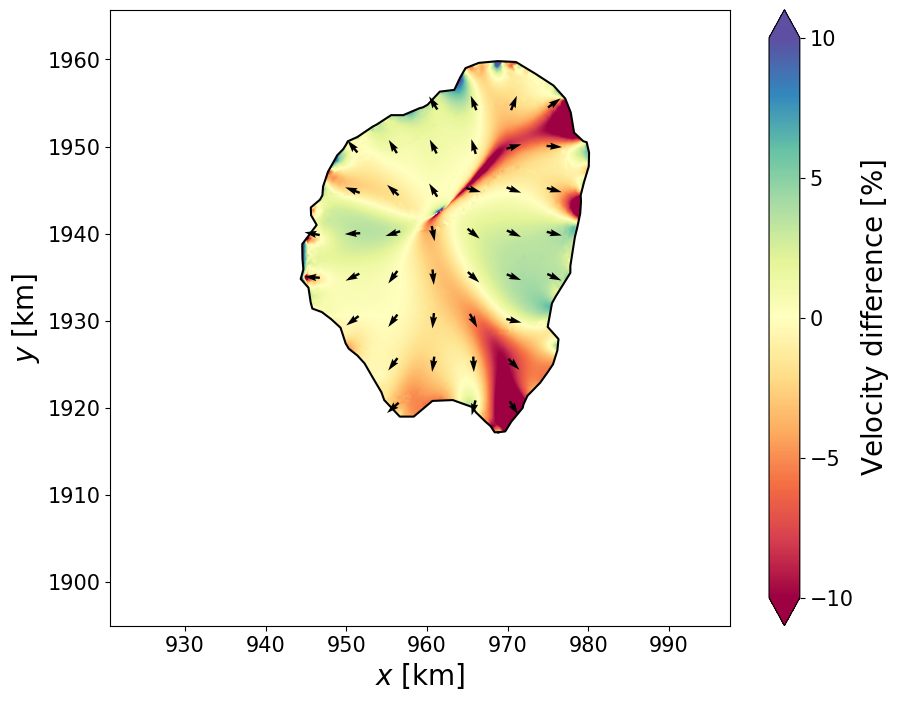

In [14]:
# Plot velocity difference

fig, ax = plt.subplots(1, 1, figsize=(10, 8))
CS = ax.contourf(grid_x/1000, grid_y/1000, VelDiffPerc1000, levels=np.linspace(-10.0, 10.0, 500), cmap="Spectral", extend = 'both')
skip = (slice(None, None, 50), slice(None, None, 50))
ax.quiver(grid_x[skip]/1000, grid_y[skip]/1000, vx_norm[Sims[2]][skip], vy_norm[Sims[2]][skip], scale=40, pivot='mid')
ax.plot(hull_pts[0], hull_pts[1], color='black')
ax.set_xlabel(r'$x$ [km]', size=20)
ax.set_ylabel(r'$y$ [km]', size=20)
ax.tick_params(axis='both', labelsize=15)
cbar = fig.colorbar(CS, ticks=[-10, -5, 0, 5, 10])
cbar.ax.tick_params(labelsize=15)
cbar.set_label('Velocity difference [$\%$]', size=20)
fig.savefig('../Figures/DerwaelVelocityDifference1000.jpg', format='jpg', dpi=700, bbox_inches = "tight")
